# Fraud detection with ML

                                                                                                    Hurgland-Nick KELIET

- La Détection de Fraud est un sujet majeur qui occupe une place très importante dans les missions des institutions financières tels que les banques et les instances de paiement en lignes. Ces institutions se sont centrés dans la detection de manoeuvres frauduleuses. Pour ce faire grace au Machine Learning nous allons découvrir comment créer un model de classification pour identifier ces transactions dites Frauduleuses, par carte grâce à un dataset contenant différentes transactions.
- ici le but est de trouver la meilleur méthode, mais également le meilleur algorithme de Machine Learning qui pourra nous permettre de détecter ces anomalies. Sachant que les données de détection de frauds sont connu pour être déséquilibrés, Biaisés.



### Importation des librairies 

In [4]:
# Import des bibliothèques Pandas et numpy pour manipuler les dataframes
import pandas as pd
import numpy as np

# Import des bibliothèques de visualisation
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
sns.set()
#sns.set_style("dark")
sns.set_palette("colorblind")


# Machine Learning
# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression # Régression Logistique
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Random Forest et Gradient Boost
from sklearn.naive_bayes import BernoulliNB # Naïve Bayes

# Metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, roc_curve, auc

# Technique d'Oversampling
'''
# check the current setting for the 'max_rows' and 'max_columns' option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# SQL import for query quickly
#import pandasql as pdsql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

'''
# Import collection.Counter
from collections import Counter

# Import de Pandas_profiling
import pandas_profiling

# Eviter warnings
import warnings
warnings.filterwarnings('ignore')

### Chargement des données

In [5]:
# Import des données du fichier csv nommée 'credit_card_file'
fraud_file = pd.read_csv("credit_card_file.csv")

# Visualisons les 5 premières lignes 
fraud_file.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


On peut voir sur le tableau ci-dessus que notre fichier, sur les 31 columns, possède 2 variables ou features non anonymisés (Amount & Time) et 29 features anonymisés (de V1 à V28).
- Time : Les secondes écoulées entre chaque transaction et la première transaction dans le dataset
- Class: ( Fraud == 1 et non_Fraud == 0 )
- V1 - V28: On peut remarquer que ces features sont anonymisés pour protéger l'id des utilisateurs mais égalemen de ceux qui est de la sensibilité de ces Features. (Cet anonymisation est la résultante de la réduction de la dimensionalité PCA) 

In [6]:
# La taille du dataset
print('Notre fichier contient {} lignes et {} colonnes'.format(fraud_file.shape[0],fraud_file.shape[1]))

Notre fichier contient 284807 lignes et 31 colonnes


# EDA

In [7]:
# Description statistique de notre dataset 
fraud_file.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
# Vérifions les noms et les types de nos features
print(fraud_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
# Vérifions si il y'a des données manquantes
print(fraud_file.isnull().sum())
print('------------------------------------')
print('are there any missing values?', fraud_file.isna().values.any())
print('------------------------------------')

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
------------------------------------
are there any missing values? False
------------------------------------


    - Nous pouvons constater qu'il n'y a point de données manquantes

### Le dataset est-il équilibré ou Déséquilibré?

In [10]:
# Séparons La variable class en 2 Classes (fraud et non_fraud)
# Fraud
fraud = fraud_file[fraud_file.Class == 1]
# Non Fraud
non_fraud = fraud_file[fraud_file.Class == 0]

* Methode 1 (Naïve approche)

In [11]:
# (taille Fraud / taille totale) * 100
print('Pourcentage de fraud:', (len(fraud) / len(fraud_file)) * 100,"%")

# (taille Non_Fraud / taille totale) * 100
print('Pourcentage de non_fraud:', (len(non_fraud) / len(fraud_file)) * 100,"%")

# Ou encore calculons la fraction aberrante
print('Nombre de fraud / Nombre de cas non fraudulent =', (len(fraud) / len(non_fraud)))

Pourcentage de fraud: 0.1727485630620034 %
Pourcentage de non_fraud: 99.82725143693798 %
Nombre de fraud / Nombre de cas non fraudulent = 0.0017304750013189597


D'après ce qui précède, on peut déduire que ce jeu de donnée est biaisé avec seulement 0.17% d'exemple de cas fraulents. Ou encore en déduire que on si l'on veut on peut avoir une précision de 99.83% en prédisant que chaque exemple n'est en aucun cas fraudulent.
Mais cette approche du problème serait erronée et ne nous permettrait pas de résoudre le problème.
Nous devons donc optimiser le taux de rappel(Recall) = TP/(TP+FN). 

Une autre manière de voir si une classe est déséquilibrée (imbalanced), est de voir si notre classe est 60/40 ou en 50/50, dans le cas contraire, nous sommes bien en face à des données non équilibrées. dans ce cas il faudrait rééquilibrer nos données soit par des méthodes de sous échantillonnage ( dans ce cas, utiliser la classe la plus petite et selectionner de manière aléatoire le même nombre de classes mojoritaire plusieurs fois pour créer plusieurs ensembles de données, puis combiner les résultats de la classification) ce qui est sans pertes d'informations.  
Dans un autre cas, on peut utiliser des méthodes de suréchantillonnage (Oversampling), qui sera expliqué de manière brève plus tard ou encore des methode comme le Boosting qui pourrait modifier les poids et les données d'équilibre de cette façon.



* Methode 2

**Exploration de  la variable Class**

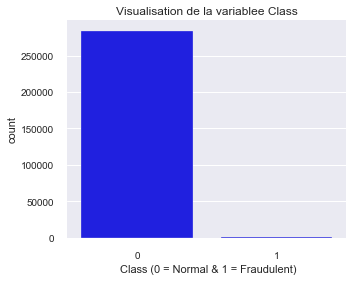

In [13]:
# Paramètre Affichage des graphes
plt.rcParams["figure.figsize"] = [5,4]
# Distribution de notre target, la variable dépendante "Class"
sns.countplot('Class', data = fraud_file, color='blue')
plt.title("Visualisation de la variablee Class")
plt.xlabel(" Class (0 = Normal & 1 = Fraudulent)")
plt.draw()

In [14]:
print('Nombre de transaction Normal:',fraud_file['Class'].value_counts().values[0])
print('Nombre de transaction Frauduleuses:',fraud_file['Class'].value_counts().values[1])

Nombre de transaction Normal: 284315
Nombre de transaction Frauduleuses: 492


**Normalisons le label Class**

In [15]:
fraud_file.Class.value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

***Conclusion***
- Comme on peut encore le voir par cette deuxième approche, on peut voir que le dataset est très déséquilibré.
- La class minoritaire(Class == 1) compte juste pour 0.002% d'exemples sur 0.99 pour la class majoritaire(Class == 0).

**Comment traité ce type de données déséquilibré (Unbalanced) ?**
 Plusieurs méthodes existes (Pozzolo 2015 google ;-)):
 1. Au niveau des données - Preprocessing pour rééquilibrer l'ensemble des données ou encore supprimer le bruit entre les deux classes.
   * Echantillonage
   * Ensemble
   * Basé sur les coût (échantillonner les données pour reproduire les différents coûts associés à chaque classe)
   * Basé sur la distance
   * Hybrid
 2. Au niveau Algorithmique - les algorithmes sont ajustés pour gérer la détection des classes minoritaires
   * Les classificateurs qui sont spécialement conçus pour gérer la distribution déséquilibrée
   * Les classificateurs qui minimisent le coût de classification global (classificateurs sensibles au coût, minimisent directement les coûts en utilisant la fonction de perte spécifique au coût)
   
   ***Quelques méthodes d'échantillonnage proposées dans la littérature:***
     * Sous-échantillonnage aléatoire.
     * Suréchantillonnage:
         * Suréchantillonnage aléatoire
         * Approche d'échantillonnage synthétique adaptative pour l'apprentissage déséquilibré (ADASYN)
         * Technique de suréchantillonnage des minorités synthétiques (SMOTE)
         * Technique de suréchantillonnage minoritaire synthétique modifiée (MSMOTE)
     * Combinaison de sur et sous-échantillonnage (échantillonnage hybride)
         * SMOTE et les voisins les plus proches modifiés (SMOTEENN)
         * Liens SMOTE et Tomek (SMOTETomek)
         * Prétraitement sélectif des données déséquilibrées (SPIDER)
     
 

### Exploration des features non anonymisés par des Visualisations

**Exploration de la variable 'Time'**

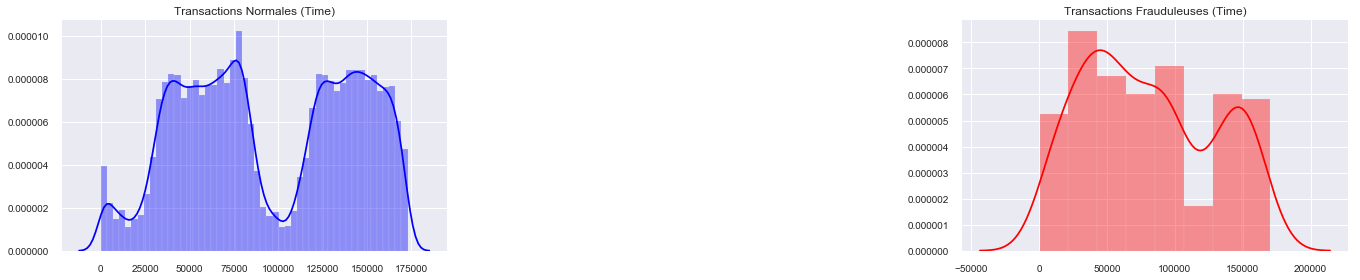

In [17]:
# Paramètre Affichage des graphes
plt.rcParams["figure.figsize"] = [19,4]

# Récupérer les valeurs de la variable Time pour les différentes Classes
fraud_time = fraud.Time.values
non_fraud_time = non_fraud.Time.values

# Graph 1 - Transactions Non Frauduleuses
plt.subplot(131)
sns.distplot(non_fraud_time, color ='blue')
plt.title("Transactions Normales (Time)")

# Graph 2 - Transactions Frauduleuses
plt.subplot(133)
sns.distplot(fraud_time, color ='red')
plt.title("Transactions Frauduleuses (Time)")

# Agencement des graphiques
plt.tight_layout()
plt.draw()


**Exploration de la variable 'Amount'**

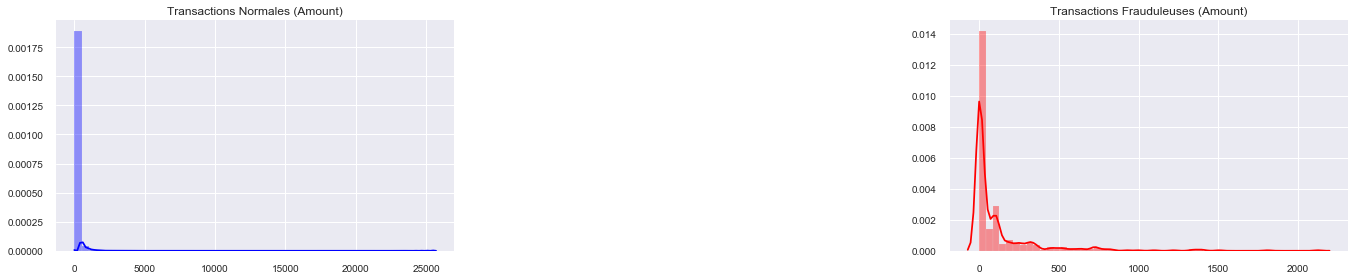

In [18]:
# Paramètre Affichage des graphes
plt.rcParams["figure.figsize"] = [19,4]

# Récupérer les valeurs de la variable Amount pour les différentes Classes
fraud_amt = fraud.Amount.values
non_fraud_amt = non_fraud.Amount.values

# Graph 1 - Transactions Non Frauduleuses
plt.subplot(131)
sns.distplot(non_fraud_amt, color ='blue')
plt.title("Transactions Normales (Amount)")

# Graph 2 - Transactions Frauduleuses
plt.subplot(133)
sns.distplot(fraud_amt, color ='red')
plt.title("Transactions Frauduleuses (Amount)")

# Agencement des graphiques
plt.tight_layout()
plt.draw()

*Ici la Variable **Time** qui est saisonnière sera transformer dans la phase de préprocessing en 1 période, ce qui réduira la variance sans perte d'information.*

**Exploration des features anonymisés grâce à la librairie gridspec**

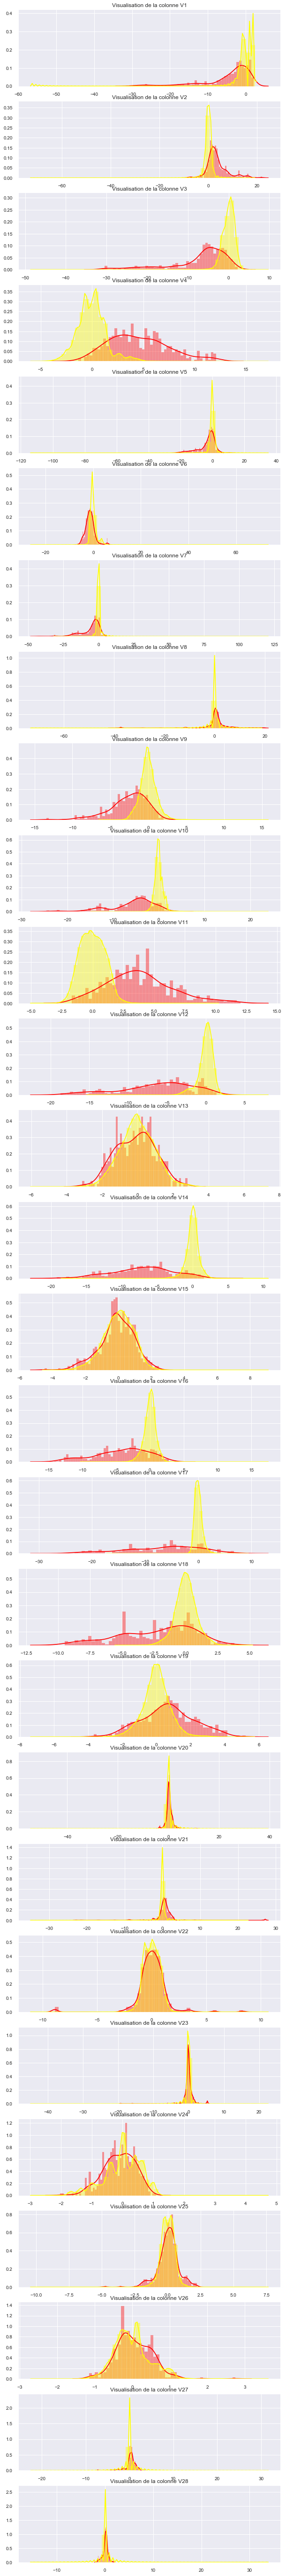

In [20]:
# Sélectionnons les colonnes anonymisées dont nous voulons analyser la distribution (features qui contiennent des anomalies)
feature_anonym = fraud_file.iloc[:,1:29].columns

# Paramètre de visualisation
plt.figure(figsize = (10,25*4))
gridSp = gridspec.GridSpec(28,1)
for i, c in enumerate(fraud_file[feature_anonym]):
    ax = plt.subplot(gridSp[i])
    sns.distplot(fraud_file[c][fraud_file['Class'] == 1], bins = 50, color = 'red')
    sns.distplot(fraud_file[c][fraud_file['Class'] == 0], bins = 50, color = 'yellow')
    ax.set_xlabel('')
    ax.set_title('Visualisation de la colonne ' + str(c))
plt.show()

#### Correlation

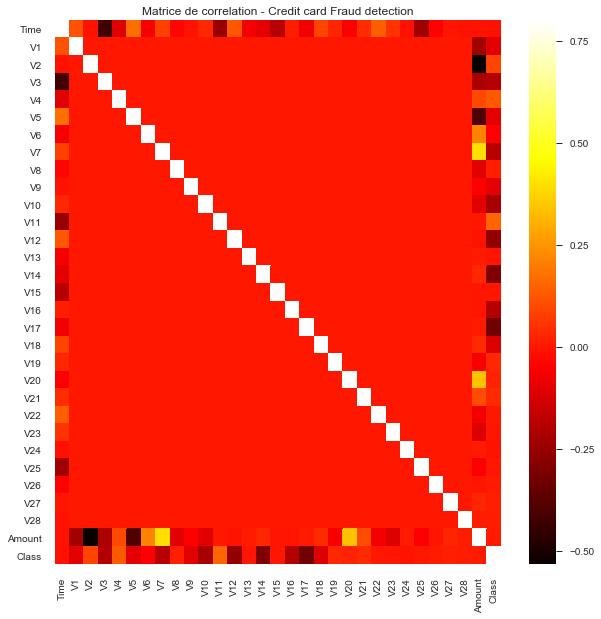

In [21]:
# Réglage 
plt.figure(figsize = (10,10))
# Créons une instance correlation
correlation = fraud_file.corr()

# Visualisation de la corrélation en utilsant la fonction Heatmap de matplotlib
sns.heatmap(correlation, cmap = 'hot', vmax = 0.8)
plt.title("Matrice de correlation - Credit card Fraud detection")
plt.draw()

*On peut voir une forte corrélation entre:*
   * *V7  et Amount* 
   * *V20 et Amount*  
   
Mais dans ce cas, l'élimination des variables faiblement corrélées ne vas pas aidé à améliorer l'algorithme.

# Pre-Processing The Data

**Séparons les variables dépendantes de notre variable à prédire (Target)**

In [22]:
# Features
X_features  = fraud_file.iloc[:,:-1]
# Target (Class)
y_target = fraud_file.loc[:,'Class']

# Vérifions nos variables
print('Taille Feature:',X_features.shape)
print('Taille Target:',y_target.shape)

# Autres méthodes 
# Méthode 1
# X = fraud_file.iloc[:,fraud_file.columns != 'Class'].values
# y = fraud_file.iloc[:,fraud_file.columns == 'Class'].values

# Méthode 2
#X = fraud_file.drop(['Class'], axis = 1)
#y = fraud_file['Class']

Taille Feature: (284807, 30)
Taille Target: (284807,)


**Standardisons les données (Standardize)**  
*Ici nous allons mettre à l'échelle les données pour avoir une moyenne et une variance d'unité nulles*>

In [23]:
# Import de la librairie StandartScaler
from sklearn.preprocessing import StandardScaler

# Instancions StandardScaler()
Scaler = StandardScaler().fit_transform(X_features)

**Partitionnons nos données en données d'Entraînement et Test**  
*Ici nous allons partitionner nos données en utilisons 70:30 mix (70% entraînement et 30% test)*

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 40)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 30)
(85443, 30)
(199364,)
(85443,)


# METHODE 1 : ADASYN (Adaptive Synthetic)

**Echantillonnage des données (Data Sampling)**

Nous savons que l'utilisation des algorithmes de Machine Learning sur des données déséquilibrées peuvent conduire à de grosses erreurs dans nos résultats, i.e qu'il peuvent conduire à des classifications érronées de la classe qui est minoritaire (Dans notre cas Class == 1).
Pour donc compenser le fait que les données sont déséquilibrées, c'est-à_dire tout rééquilibrer, nous pouvons utiliser une méthode que nous avons cité beaucoup plus haut, cette méthode de *suréchantillonage* nommée **ADASYN(Adaptive Synthetic)** qui est une technique **d'Oversampling** et une technique qui est génère de manière adaptative des échantillons de données minoritaires en fonction de leurs distributions en utilisant *l'algorithme des K plus proche voisin*.  
**Références:**  
http://glemaitre.github.io/imbalanced-learn/autoexamples/over-sampling/plotadasyn.html  
https://www.jeremyjordan.me/imbalanced-data/

In [26]:
# Importons la librairie ADASYN
from imblearn.over_sampling import ADASYN

# Créons une instance d'ADASYN OverSampling
adasyn = ADASYN(random_state = 42)

# Comparons la taille de nos données original et celui Resamplé par ADASYN
print('Taille original de nos données:', Counter(y_train))
# Appliquons ADASYN
X_adasyn, y_adasyn = adasyn.fit_sample(X_train, y_train)

# Vérifions la taille de nos nouvelles données
print('La Taille de nos données resamplé:', Counter(y_adasyn))

Taille original de nos données: Counter({0: 199010, 1: 354})
La Taille de nos données resamplé: Counter({0: 199010, 1: 198926})


**Aperçu de notre Class resamplé**

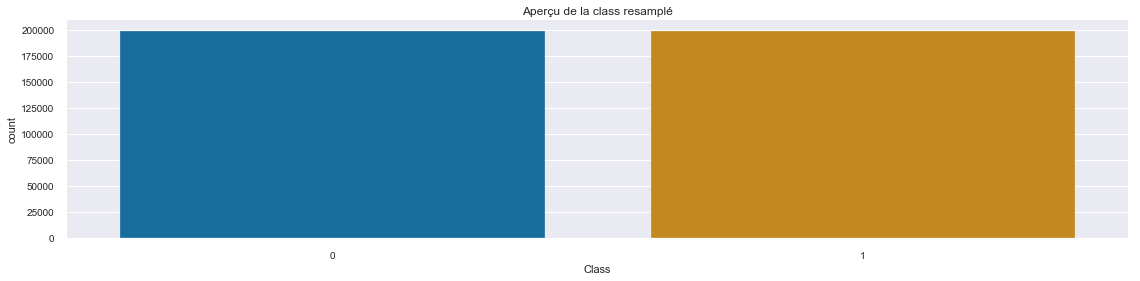

In [27]:
sns.countplot(y_adasyn)
plt.title('Aperçu de la class resamplé')
plt.show()

**Conclusion**: *Nous avons bien pu réajusté nos données grâce à ADASYN*

# Entraînement de nos modèles

Vu que nous avons pu réequilibré nos données, nous pouvons maintenant utiliser des algorithmes d'apprentissage de Classification(ML)

In [28]:
# Réassignons nous nouvelles données respectivement sur nos données de training  X_train, y_train
X_train = X_adasyn
y_train = y_adasyn
print(X_train.shape)
print(y_train.value_counts(normalize = True))

(397936, 30)
0    0.500106
1    0.499894
Name: Class, dtype: float64


*Modèles :* **Regression Logistique**, **Naïve Bayes**, **Random forest**.

In [29]:
# Instancions et entrainons le modèle de "Regression Logistique"
LR_Classifier = LogisticRegression().fit(X_train, y_train)

# Instancions et entrainons le modèle "Naïve Bayes (BernoulliNB)"
NB_Classifier = BernoulliNB().fit(X_train, y_train)

# Instancions et entrainons le modèle "Random forest"
RF_Classifier = RandomForestClassifier(random_state = 0, n_estimators = 100).fit(X_train, y_train)

# Evaluation de nos modèles d'entraînement

*Après avoir entraîner nos modèles, nous allons les évaluer.*

**Regression Logistique**

*Fonctionnement du Regression Logistique (Supervise Learning):* 

La régression logistique ou modèle logit est un modèle de régression binomiale. Comme pour tous les modèles de régression binomiale, il s'agit de modéliser au mieux un modèle mathématique simple à des observations réelles nombreuses.

======================== -- Resultat de l'évaluation du modèle -- ========================

=====================-- Regression Logistique --=====================
-----------------------
Score_training: 97.0 %
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    199010
           1       0.98      0.96      0.97    198926

    accuracy                           0.97    397936
   macro avg       0.97      0.97      0.97    397936
weighted avg       0.97      0.97      0.97    397936

-----------------------------------------------------------------------------
Confusion Matrix:
----------------


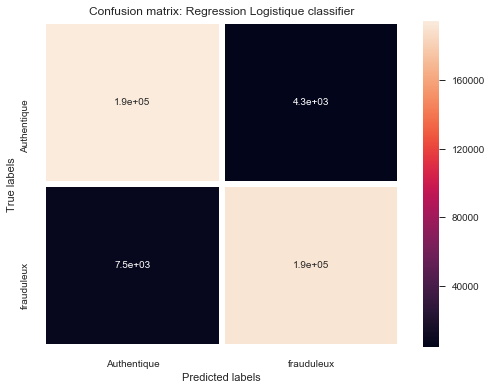

In [30]:
# Réglage 
plt.figure(figsize = (8,6))

# Predisons
#----------
y_pred_LR = LR_Classifier.predict(X_train)

# Performance et metriques
#-------------------------
#score = cross_val_score(LR_Classifier, X_train, y_train, cv = 10)
accuracy = accuracy_score(y_train, y_pred_LR)
class_report = classification_report(y_train,y_pred_LR)
confusion_matrix_RL = confusion_matrix(y_train, y_pred_LR)

# Affichage
#----------
print('======================== -- Resultat de l\'évaluation du modèle -- ========================' "\n")
print('=====================-- Regression Logistique --=====================')
#print('Score:', round(score.mean(),3) * 100,'%')
print('-----------------------')
print("Score_training:", round(accuracy,3) * 100,'%')
print('-----------------------------------------------------------------------------')
print("Classification report:" "\n", class_report)
print('-----------------------------------------------------------------------------')
print("Confusion Matrix:")
print('----------------')
ax = plt.subplot()
sns.heatmap(confusion_matrix_RL, annot = True, ax = ax, linewidths = 5); 

# Étiquettes, Titre
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix: Regression Logistique classifier'); 
ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
plt.show()

**Naïve Bayes**

*Fonctionnement du Naïve Bayes (Supervise Learning):* 

L'algorithme **Naïve Bayes** est une méthode d'apprentissage de **classification**, qui fonctionnent sur le principe des **probabilités conditionnelles** comme donnée dans le théoreme des bayes. Le théorème de Bayes calcule essentiellement la probabilité conditionnelle de l'occurrence d'un événement en se basant sur la connaissance préalable des conditions qui pourraient être liées à l'événement.
* gère les données continues et discrètes.
* Cet algorithme nécessite moins de données d'entraînement.
* Hautement évolutif avec nombre de prédicteurs et de points de données.
* comme il est rapide, il peut être utilisé dans les prédictions en temps réel.

======================== -- Resultat de l'évaluation du modèle -- ========================

=====================-- Naïve Bayes: BernoulliNB --=====================
-----------------------
Score_training: 94.1 %
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94    199010
           1       1.00      0.89      0.94    198926

    accuracy                           0.94    397936
   macro avg       0.95      0.94      0.94    397936
weighted avg       0.95      0.94      0.94    397936

-----------------------------------------------------------------------------
Confusion Matrix:
----------------


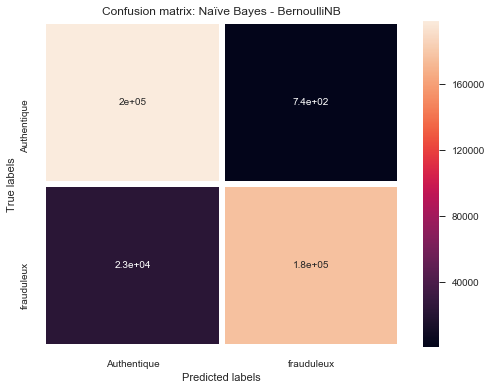

In [31]:
# Réglage
#--------
plt.figure(figsize = (8,6))

# Predisons
#----------
y_pred_NB = NB_Classifier.predict(X_train)

# Performance et metriques
#-------------------------
#score = cross_val_score(NB_Classifier, X_train, y_train, cv = 10)
accuracy = accuracy_score(y_train, y_pred_NB)
class_report = classification_report(y_train,y_pred_NB)
confusion_matrix_NB = confusion_matrix(y_train, y_pred_NB)

# Affichage
#----------
print('======================== -- Resultat de l\'évaluation du modèle -- ========================' "\n")
print('=====================-- Naïve Bayes: BernoulliNB --=====================')
#print('Score:', round(score.mean(),3) * 100,'%')
print('-----------------------')
print("Score_training:", round(accuracy,3) * 100,'%')
print('-----------------------------------------------------------------------------')
print("Classification report:"  "\n", class_report)
print('-----------------------------------------------------------------------------')
print("Confusion Matrix:")
print('----------------')
ax= plt.subplot()
sns.heatmap(confusion_matrix_NB, annot = True, ax = ax, linewidths = 5);

# Étiquettes, Titre
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion matrix: Naïve Bayes - BernoulliNB'); 
ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
plt.show()

**Random forest**

*Fonctionnement du Random Forest (Supervise Learning):*  



L'algorithme **Random Forest** (*forêt aléatoire ou forêt de decision*) est une méthode d'apprentissage d'ensemble pour la régression, la **classification** et bien d'autres tâches encore, qui fonctionnent en construisant une multitude d'arbres de décision au moment de la formation et en produisant la classe qui est le mode des classes ou la prédiction moyenne (*régression*). Des arbres individuels crée un ensemble d'arbres de décision à partir d'un sous-ensemble sélectionné au hasard d'un ensemble d'apprentissage. Il agrège ensuite les votes des différents arbres de décision pour décider de la classe finale de l'objet de test. Utiliser l'algorithme du Random Forest **réduit le risque d'Overfitting** (*surajustement*) et **le temps d'entrainement est moindre**, ce qui améliorera la précision du modèle sur les nouvelles données afin de créer des apprenants forts pour générer des prédictions précises. Nous pouvons aussi finir en disant que l'algorithme des forêts aléatoires **tourne efficacement sur de grosses base de données**, ce qui produit **des prédictions très précises** même lorsque qu'une large proportion de **données sont manquantes**.

======================== -- Resultat de l'évaluation du modèle -- ========================

=====================-- Random forest --=====================
-----------------------
Score_training: 100.0 %
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199010
           1       1.00      1.00      1.00    198926

    accuracy                           1.00    397936
   macro avg       1.00      1.00      1.00    397936
weighted avg       1.00      1.00      1.00    397936

-----------------------------------------------------------------------------
Confusion Matrix:
----------------


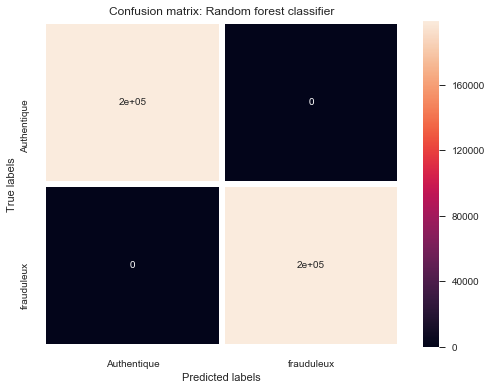

In [33]:
# Réglage
#--------
plt.figure(figsize = (8,6))

# Predisons
#----------
y_pred_RF = RF_Classifier.predict(X_train)

# Performance et metriques
#-------------------------
#score = cross_val_score(RF_Classifier, X_train, y_train, cv = 10)
accuracy = accuracy_score(y_train, y_pred_RF)
class_report = classification_report(y_train,y_pred_RF)
confusion_matrix_RF = confusion_matrix(y_train, y_pred_RF)

# Affichage
#----------
print('======================== -- Resultat de l\'évaluation du modèle -- ========================' "\n")
print('=====================-- Random forest --=====================')
#print('Score:', round(score.mean(),3) * 100,'%')
print('-----------------------')
print("Score_training:", round(accuracy,3) * 100,'%')
print('-----------------------------------------------------------------------------')
print("Classification report:"  "\n", class_report)
print('-----------------------------------------------------------------------------')
print("Confusion Matrix:")
print('----------------')
ax= plt.subplot()
sns.heatmap(confusion_matrix_RF, annot = True, ax = ax, linewidths = 5);

# Étiquettes, Titre
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion matrix: Random forest classifier'); 
ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
plt.show()

# Test de nos modèles sur les données de Test 

*Après avoir entraîner nos modèles de test çi-dessus, nous allons maintenant les tester sur nos données de Test qui possède 30% du dataset.*

**Regression Logistique**, **Naïve Bayes**, **Random forest** !!

======================== -- Resultat de l'évaluation du Test -- ========================

=====================-- Logistic_Regression_Classifier --=====================
-----------------------
Score_test: 97.8 %
-----------------------------------------------------------------------------
Le nombre d'erreur est de: 1867
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85305
           1       0.06      0.91      0.12       138

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

-----------------------------------------------------------------------------
ROC AUC: 0.945648988412423
-----------------------------------------------------------------------------
Confusion Matrix:
----------------


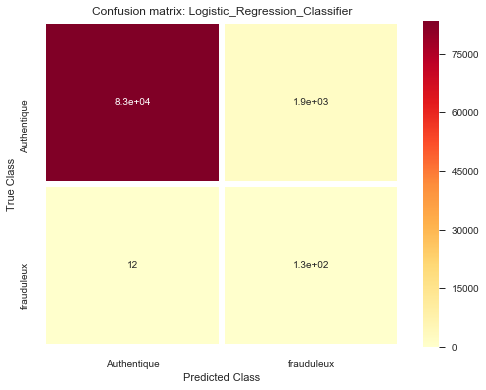

<Figure size 576x432 with 0 Axes>


=====================-- BernoulliNB --=====================
-----------------------
Score_test: 99.6 %
-----------------------------------------------------------------------------
Le nombre d'erreur est de: 346
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.26      0.81      0.39       138

    accuracy                           1.00     85443
   macro avg       0.63      0.90      0.70     85443
weighted avg       1.00      1.00      1.00     85443

-----------------------------------------------------------------------------
ROC AUC: 0.9039214786839042
-----------------------------------------------------------------------------
Confusion Matrix:
----------------


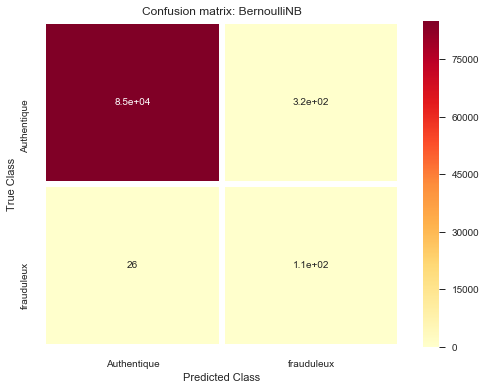


=====================-- Random_Forest_Classifier --=====================
-----------------------
Score_test: 100.0 %
-----------------------------------------------------------------------------
Le nombre d'erreur est de: 37
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.90      0.82      0.86       138

    accuracy                           1.00     85443
   macro avg       0.95      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443

-----------------------------------------------------------------------------
ROC AUC: 0.9093499540013711
-----------------------------------------------------------------------------
Confusion Matrix:
----------------


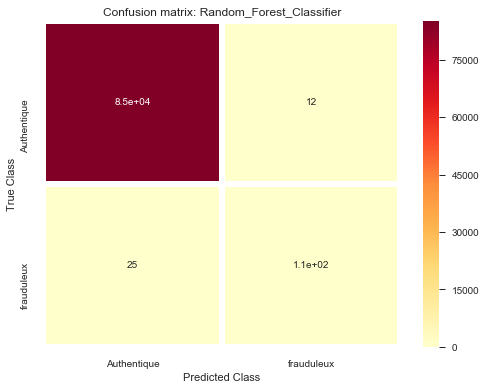


================================= ROC CURVE ==============================


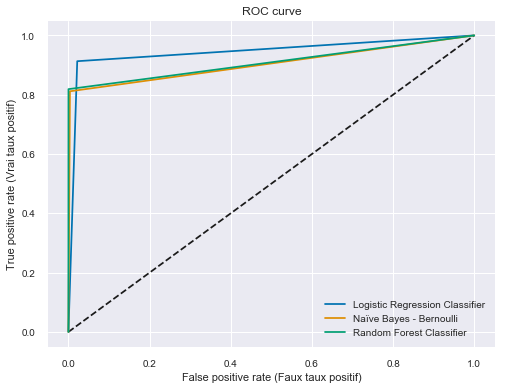

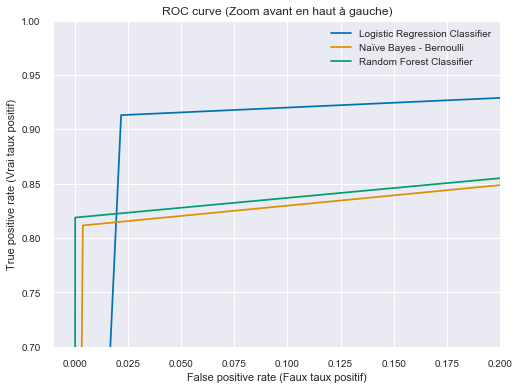

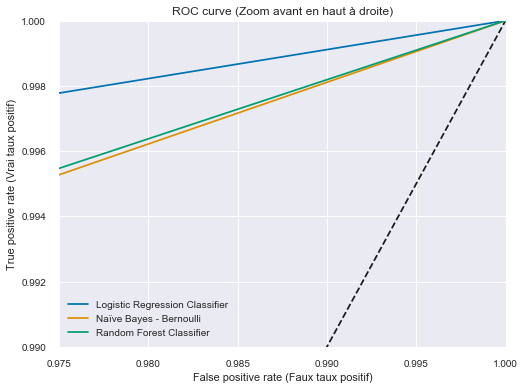

In [40]:
from sklearn.metrics import f1_score,recall_score,precision_score
# En-tête
#--------
print('======================== -- Resultat de l\'évaluation du Test -- ========================' "\n")

# Réglage
#--------
plt.figure(figsize = (8,6))

# Créons une liste des modèles
#-----------------------------
liste_modeles = [('Logistic_Regression_Classifier', LR_Classifier), ('BernoulliNB', NB_Classifier), ('Random_Forest_Classifier', RF_Classifier)]
modeles = [ m for m in liste_modeles]

# Créons deux dictionnaire pour accueillir une les différents résultats des différentes courbes d'apprentissages
f = {}
t = {}

for i, mod in modeles:   
# Réglage pour chaque matrice de confusion
#-----------------------------------------
    plt.figure(figsize = (8,6))
    
# Predisons
#----------
    y_pred = mod.predict(X_test)
    
# Performance et metriques
#-------------------------
    #score = cross_val_score(mod, X_test, y_test, cv = 10)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test,y_pred)
    conf_matx = confusion_matrix(y_test, y_pred)
    n_error = (y_pred != y_test).sum()
    f['fpr_' + i], t['tpr_' + i] , _ = roc_curve(y_test, y_pred)
    
# Affichage
#----------
    print('=====================-- {} --====================='.format(i))
    #print('Score:', round(score.mean(),3) * 100,'%')
    print('-----------------------')
    print("Score_test:", round(accuracy,3) * 100,'%')
    print('-----------------------------------------------------------------------------')
    print("Le nombre d'erreur est de: {}".format(n_error))
    print('-----------------------------------------------------------------------------')
    print("Classification report:"  "\n", class_report)
    print('-----------------------------------------------------------------------------')
    # Calcul ROC_AUC_SCORE
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print ('ROC AUC:',roc_auc)
    print('-----------------------------------------------------------------------------')
    print("Confusion Matrix:")
    print('----------------')
    
    plt.figure(1)
    ax= plt.subplot()
    sns.heatmap(conf_matx, annot = True, ax = ax, cmap = 'YlOrRd', linewidths = 5);
    # Étiquettes, Titre
    ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class');
    ax.set_title('Confusion matrix: {}'.format(i)); 
    ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
    plt.show()
    
    print('')
    
# Roc Curve
print('================================= ROC CURVE ==============================')
plt.figure(figsize = (8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(f['fpr_Logistic_Regression_Classifier'], t['tpr_Logistic_Regression_Classifier'], label='Logistic Regression Classifier')
plt.plot(f['fpr_BernoulliNB'], t['tpr_BernoulliNB'], label='Naïve Bayes - Bernoulli')
plt.plot(f['fpr_Random_Forest_Classifier'], t['tpr_Random_Forest_Classifier'], label='Random Forest Classifier')
plt.xlabel('False positive rate (Faux taux positif)')
plt.ylabel('True positive rate (Vrai taux positif)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Roc Curve 2 Zoomé
plt.figure(figsize = (8,6))
plt.xlim(-0.01, 0.2)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(f['fpr_Logistic_Regression_Classifier'], t['tpr_Logistic_Regression_Classifier'], label='Logistic Regression Classifier')
plt.plot(f['fpr_BernoulliNB'], t['tpr_BernoulliNB'], label='Naïve Bayes - Bernoulli')
plt.plot(f['fpr_Random_Forest_Classifier'], t['tpr_Random_Forest_Classifier'], label='Random Forest Classifier')
plt.xlabel('False positive rate (Faux taux positif)')
plt.ylabel('True positive rate (Vrai taux positif)')
plt.title('ROC curve (Zoom avant en haut à gauche)')
plt.legend(loc='best')
plt.show()

# Roc Curve 3 Zoomé
plt.figure(figsize = (8,6))
plt.xlim(0.975, 1)
plt.ylim(0.99, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(f['fpr_Logistic_Regression_Classifier'], t['tpr_Logistic_Regression_Classifier'], label='Logistic Regression Classifier')
plt.plot(f['fpr_BernoulliNB'], t['tpr_BernoulliNB'], label='Naïve Bayes - Bernoulli')
plt.plot(f['fpr_Random_Forest_Classifier'], t['tpr_Random_Forest_Classifier'], label='Random Forest Classifier')
plt.xlabel('False positive rate (Faux taux positif)')
plt.ylabel('True positive rate (Vrai taux positif)')
plt.title('ROC curve (Zoom avant en haut à droite)')
plt.legend(loc='best')
plt.show()

**CONCLUSION:**  
D'après ce qui précède on peut voir que **l'algorithme du Random Forest** (*Forêt aléatoire*) présente **le meilleur résulat** parmi les autres : *La Regression Logistique* et *Naïve Bayes - Bernoulli*.

###  METHODE 2: SMOTE(Synthetic Minority Oversampling Technique)

In [35]:
# Import de lightgbm
from imblearn.over_sampling import SMOTE
X_train_sm, y_train_sm = SMOTE().fit_sample(X_train, y_train)

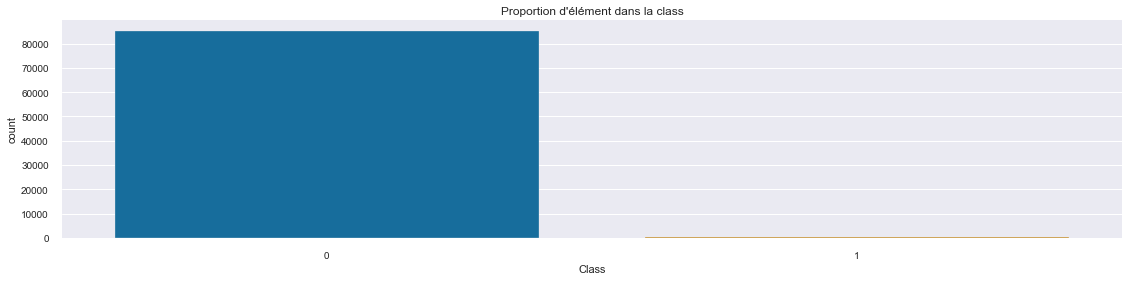

In [36]:
# revérifions la proportion des données dans la Class
sns.countplot(y_test)
plt.title('Proportion d\'élément dans la class')
plt.show()

**Random Forest avec les données Resamplé**

In [37]:
# Réentraînons le modele RF avec nos données Resamplées
rf_resampled = RandomForestClassifier(n_estimators = 100).fit(X_train_sm,y_train_sm)

======================== -- Resultat de l'évaluation du modèle -- ========================

=====================-- Random forest avec SMOTE --=====================
-----------------------
Score_test: 100.0 %
-----------------------------------------------------------------------------
Le nombre d'erreur est de: 37
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85305
           1       0.90      0.83      0.86       138

    accuracy                           1.00     85443
   macro avg       0.95      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443

-----------------------------------------------------------------------------
Confusion Matrix:
----------------


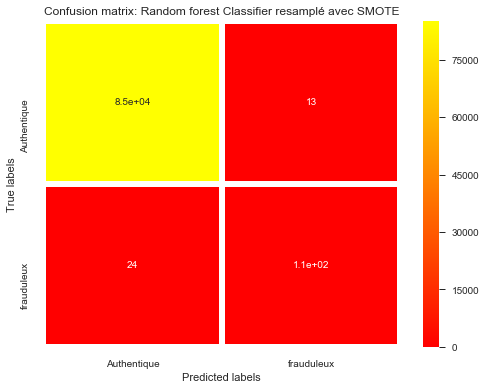

-----------------------------------------------------------------------------
ROC AUC: 0.9129672810860264
-----------------------------------------------------------------------------

===================== ROC CURVE - Random Forest avec SMOTE ==================


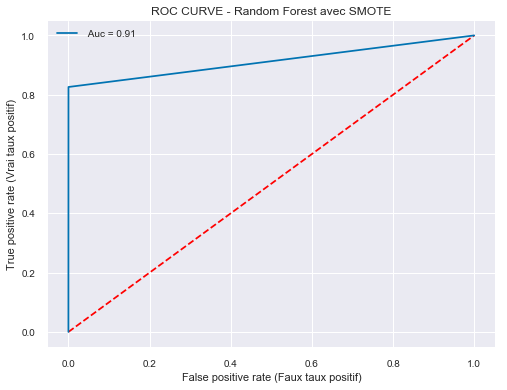

In [38]:
y_test_sm = y_test
# Réglage
#--------
plt.figure(figsize = (8,6))

# Predisons
#----------
y_pred_rf_resampled = rf_resampled.predict(X_test)

# Performance et metriques
#-------------------------
#score = cross_val_score(RF_Classifier, X_train, y_train, cv = 10)
accuracy = accuracy_score(y_test, y_pred_rf_resampled)
class_report = classification_report(y_test,y_pred_rf_resampled)
cm_rf_resampled_smote = confusion_matrix(y_test,y_pred_rf_resampled)
n_error = (y_pred_rf_resampled != y_test).sum()

# Affichage
#----------
print('======================== -- Resultat de l\'évaluation du modèle -- ========================' "\n")
print('=====================-- Random forest avec SMOTE --=====================')
#print('Score:', round(score.mean(),3) * 100,'%')
print('-----------------------')
print("Score_test:", round(accuracy,3) * 100,'%')
print('-----------------------------------------------------------------------------')
print("Le nombre d'erreur est de: {}".format(n_error))
print('-----------------------------------------------------------------------------')
print("Classification report:"  "\n", class_report)
print('-----------------------------------------------------------------------------')
print("Confusion Matrix:")
print('----------------')
ax= plt.subplot()
sns.heatmap(cm_rf_resampled_smote, cmap = 'autumn', annot = True, linewidths = 5, ax = ax)

# Étiquettes, Titre
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion matrix: Random forest Classifier resamplé avec SMOTE'); 
ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
plt.show()

print('-----------------------------------------------------------------------------')
# Calcul ROC_AUC
false_positive_rate_rf_smote, true_positive_rate_rf_smote, thresholds = roc_curve(y_test, y_pred_rf_resampled)
roc_auc = auc(false_positive_rate_rf_smote, true_positive_rate_rf_smote)
print ('ROC AUC:',roc_auc)
print('-----------------------------------------------------------------------------')
print('')

# Roc Curve Random Forest avec SMOTE
print('===================== ROC CURVE - Random Forest avec SMOTE ==================')
plt.figure(figsize = (8,6))
plt.plot([0, 1], [0, 1], 'k--', color ='red')
plt.plot(false_positive_rate_rf_smote, true_positive_rate_rf_smote, label=' Auc = {}'.format(round(roc_auc,2)))
plt.xlabel('False positive rate (Faux taux positif)')
plt.ylabel('True positive rate (Vrai taux positif)')
plt.title('ROC CURVE - Random Forest avec SMOTE')
plt.legend(loc='best')
plt.show()

**Gradient Boosting avec les données Resamplé**

In [41]:
# Réentraînons le modele Gradient Boost avec nos données Resamplées
from sklearn.ensemble import GradientBoostingClassifier

# Paramétrons notre algorithme
parametres = {'n_estimators': 50, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

Gb_resampled = GradientBoostingClassifier(**parametres).fit(X_train_sm,y_train_sm)

======================== -- Resultat de l'évaluation du modèle -- ========================

=====================-- Random forest avec SMOTE --=====================
-----------------------
Score_test: 98.5 %
-----------------------------------------------------------------------------
Le nombre d'erreur est de: 1309
-----------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85305
           1       0.09      0.88      0.16       138

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.57     85443
weighted avg       1.00      0.98      0.99     85443

-----------------------------------------------------------------------------
Confusion Matrix:
----------------


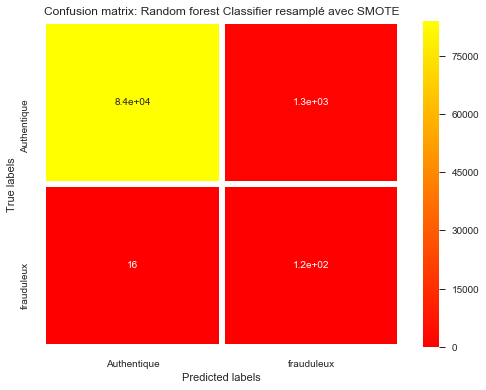

-----------------------------------------------------------------------------
ROC AUC: 0.9129672810860264
-----------------------------------------------------------------------------

===================== ROC CURVE - Gradient Boosting avec SMOTE ==================


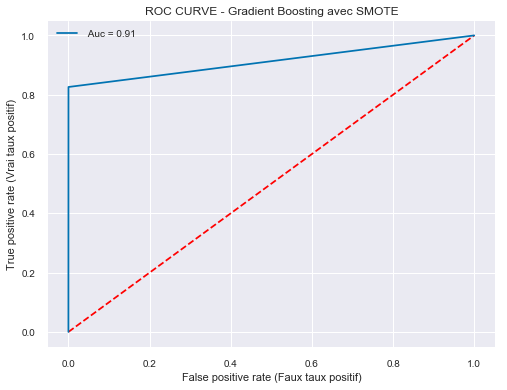

In [42]:
# Réglage
#--------
plt.figure(figsize = (8,6))

# Predisons
#----------
y_pred_gb_resampled = Gb_resampled.predict(X_test)

# Performance et metriques
#-------------------------
accuracy = accuracy_score(y_test, y_pred_gb_resampled)
class_report = classification_report(y_test,y_pred_gb_resampled)
cm_Gb_resampled_smote = confusion_matrix(y_test,y_pred_gb_resampled)
n_error = (y_pred_gb_resampled != y_test).sum()

# Affichage
#----------
print('======================== -- Resultat de l\'évaluation du modèle -- ========================' "\n")
print('=====================-- Random forest avec SMOTE --=====================')
#print('Score:', round(score.mean(),3) * 100,'%')
print('-----------------------')
print("Score_test:", round(accuracy,3) * 100,'%')
print('-----------------------------------------------------------------------------')
print("Le nombre d'erreur est de: {}".format(n_error))
print('-----------------------------------------------------------------------------')
print("Classification report:"  "\n", class_report)
print('-----------------------------------------------------------------------------')
print("Confusion Matrix:")
print('----------------')
ax= plt.subplot()
sns.heatmap(cm_Gb_resampled_smote, cmap = 'autumn', annot = True, linewidths = 5, ax = ax)

# Étiquettes, Titre
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion matrix: Random forest Classifier resamplé avec SMOTE'); 
ax.xaxis.set_ticklabels(['Authentique', 'frauduleux']); ax.yaxis.set_ticklabels(['Authentique', 'frauduleux']);
plt.show()

print('-----------------------------------------------------------------------------')
# Calcul ROC_AUC
false_positive_rate_gb_smote, true_positive_rate_gb_smote, thresholds = roc_curve(y_test, y_pred_rf_resampled)
roc_auc = auc(false_positive_rate_gb_smote, true_positive_rate_gb_smote)
print ('ROC AUC:',roc_auc)
print('-----------------------------------------------------------------------------')
print('')

# Roc Curve Gradient Boosting avec SMOTE
print('===================== ROC CURVE - Gradient Boosting avec SMOTE ==================')
plt.figure(figsize = (8,6))
plt.plot([0, 1], [0, 1], 'k--', color ='red')
plt.plot(false_positive_rate_gb_smote, true_positive_rate_gb_smote, label=' Auc = {}'.format(round(roc_auc,2)))
plt.xlabel('False positive rate (Faux taux positif)')
plt.ylabel('True positive rate (Vrai taux positif)')
plt.title('ROC CURVE - Gradient Boosting avec SMOTE')
plt.legend(loc='best')
plt.show()

En termes commerciaux dans la vrai vie, si le système classe une transaction comme Faux positif ( ie que on prédit que l'action est une fraud or l'action même (le label actuel) n'est pas fraud, l'instance de finance, ou banque pourrait mener une enquête sur le problème pour résoudre le conflit, par une intervention humaine. Par ce fait, un titulaire de carte aura des transactions incorrects. ce qui représente une baisse d'argent pour une entreprise.  

Dans un autre cas, si l'action est jugé de faux négatif, cela signifie que la transaction est frauduleuse mais n'a pas été détecté. Dans ce cas, l'instance financier ou la banque perd de l'argent.  (voir https://fr.wikipedia.org/wiki/Matrice_de_confusion )

# Conclusion:

Dans cet étude, on a pu voir des méthodes pour détecter des fraudes dans les instances financiers. Nous avons utiliser des methodes nous permettant d'avoir des résultats cohérents (**Adasyn et Smote** D'autres methodes peuvent etre utiliser pour résoudre ce même type de projet. Et même les différents algorithmes comme **l'arbre de forêt**, **Gradient Boost** que nous avons utiliser ou encore *SVM* (un autre algo) avec des paramètres ayant subi un tuning peuvent améliorer la précision de notre modèle et donc réduire le nombre d'erreur. Mais dans ce cas, le random forest à été très performant.  
Les machines vectorielles (SVM) et la régression logistique peuvent facilement fournir un score de rappel de 90% pour un ensemble de données véritablement invisible (du monde réel). ce que on pourrait tester plutard pour les SVMs ou encore avec les *KMeans (Unsupervised Learning)*.

Utiliser une **API** nous permettra de visualiser nos données en temps réel avec **Flask** ou d'autres et après d'être déployé sur serveur

                                                                                                                                END